2. Forecasting. For this problem, use cambridge.csv or cambridge.dta. The file contains
monthly means of daily maximum temperature (variable maxtemp) in Cambridge, from January
1959 up to September 2018. For example, in September 2018, the average maximum daily
temperature in Cambridge was 19.9 degrees of Celsius.


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

data = pd.read_stata("cambridge.dta")
print(data.tail())
print(data.info())

     year  month    maxtemp          t
703  2017      8  21.500000 2017-08-01
704  2017      9  18.299999 2017-09-01
705  2017     10  16.299999 2017-10-01
706  2017     11  10.200000 2017-11-01
707  2017     12   7.500000 2017-12-01
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   year     708 non-null    int16         
 1   month    708 non-null    int8          
 2   maxtemp  708 non-null    float32       
 3   t        708 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 10.5 KB
None


(a) Make a time series plot of maxtemp. Summarize the behavior of these time series. Plot
the correlogram of maxtemp. Comment.



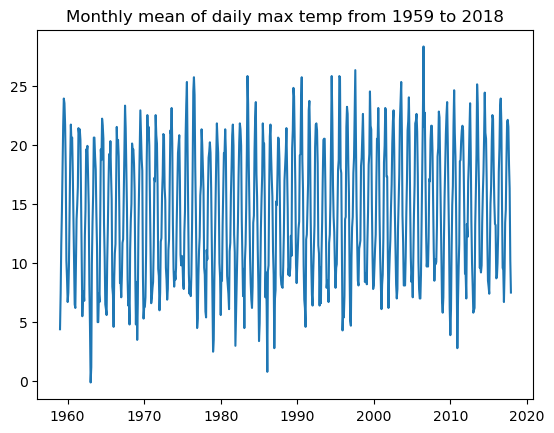

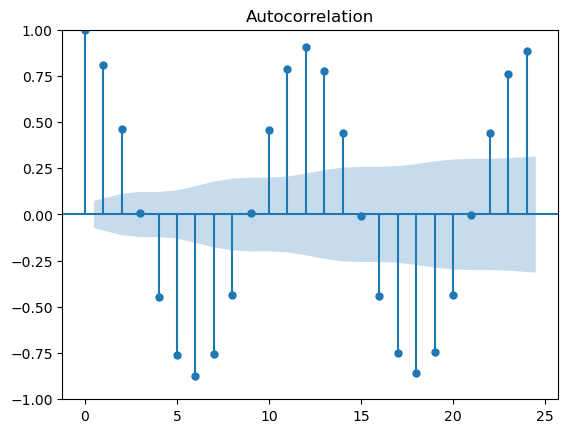

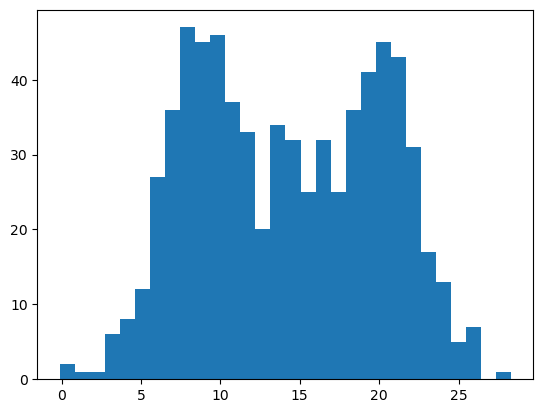

,year,month,maxtemp,t
count,708.000000,708.000000,708.000000,708
mean,1988.000000,6.500000,14.250989,1988-06-16 02:02:02.033898368
min,1959.000000,1.000000,-0.100000,1959-01-01 00:00:00
25%,1973.000000,3.750000,9.200000,1973-09-23 12:00:00
50%,1988.000000,6.500000,14.000000,1988-06-16 00:00:00
75%,2003.000000,9.250000,19.400000,2003-03-08 18:00:00
max,2017.000000,12.000000,28.299999,2017-12-01 00:00:00
std,17.041426,3.454493,5.785742,NaN


In [6]:

plt.plot(data["t"], data["maxtemp"])
plt.title("Monthly mean of daily max temp from 1959 to 2018")
plt.show()

plot_acf(data["maxtemp"], lags = 24)
plt.show()

plt.hist(data["maxtemp"], bins =30)
plt.show()

data.describe()


The data clearly follows a seasonal pattern, it is stationary and stable and oscillates around a mean of around 14.25 degrees, deviating symmetrically (albeit not quite normally) 14 degrees either way across the period.


(b) Run the regression of maxtemp on the month dummies (don’t fall into the dummy variable
trap!). How would you interpret the coeﬃcients? Save the residuals from this regression
as variable res.

In [7]:
import statsmodels.formula.api as smf

# Regression with formula (like R)
model = smf.ols('maxtemp ~ C(month)', data=data).fit()

# View results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                maxtemp   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     645.3
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:49:51   Log-Likelihood:                -1391.7
No. Observations:                 708   AIC:                             2807.
Df Residuals:                     696   BIC:                             2862.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.9441      0.227     30.

January is on average the coldest month at 6.9 degrees, and month July (T.7) is the warmest at a temperature of 15.2 degrees warmer (22.1 degrees) than January 

(c) Make a time series plot of res. Any signs of global warming? Plot a correlogram of res.
Comment.


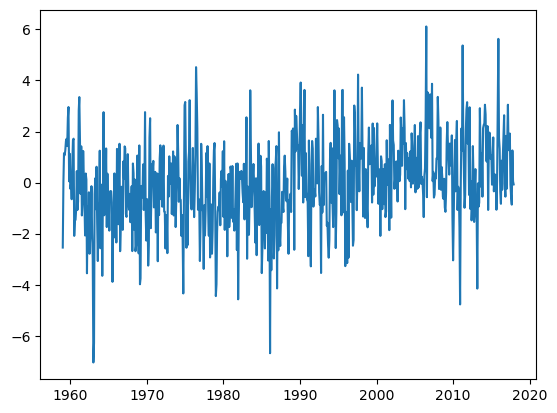

                            OLS Regression Results                            
Dep. Variable:                    res   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 18 Nov 2025   Prob (F-statistic):                nan
Time:                        20:11:48   Log-Likelihood:                -1377.6
No. Observations:                 708   AIC:                             2757.
Df Residuals:                     707   BIC:                             2762.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.006e-37   7.45e-38      5.375      0.0

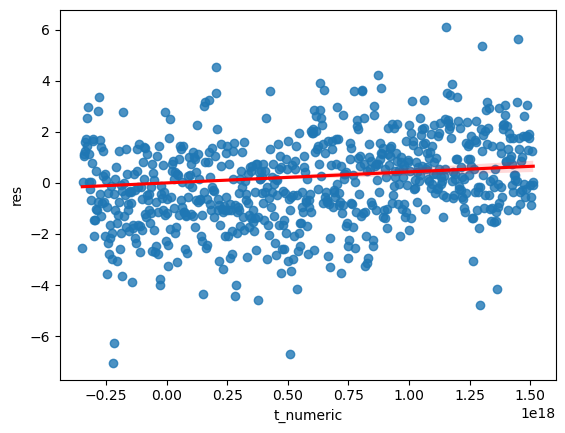

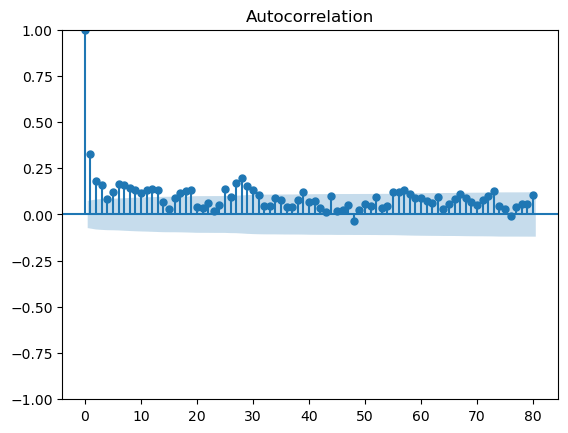

In [ ]:
#res = model.resid
data["res"] = model.resid
plt.plot(data["t"], data["res"])
plt.show()

#plot of residuals
data['t_numeric'] = pd.to_numeric(data['t'])
sns.regplot(data=data, x='t_numeric', y='res', scatter=True, line_kws={'color': 'red'})
plt.show()

#plot of res acf
plot_acf(data["res"], lags = 80)
plt.show()

Yes, the errors do look like they are they dependent on t with the mean temperature increasing almost 1 degree over the 60 year period. 

The ACF of errors suggests the 1st error is particularly strong, suggesting an AR(1) process, likely when we get slightly warmer or colder weather in a particular month we will also see it for the next month, and mildly see it for the rest of the year two, as seen with the persistence in the 10 observations or so.



(d) Regress res on variable t, which indexes time, and a constant. Save the residuals as
variable res1. Plot a correlogram of res1. Compare with the correlogram of res. Can
you explain the diﬀerence?

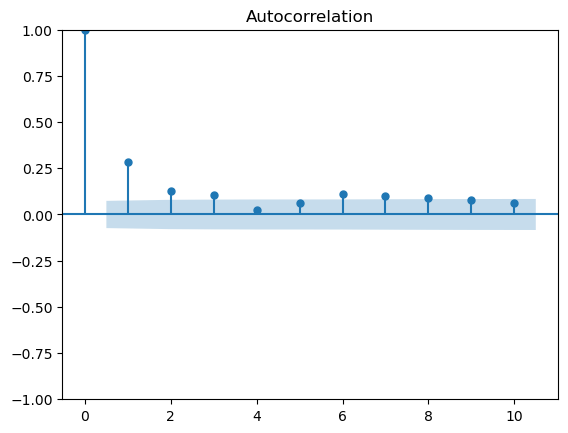

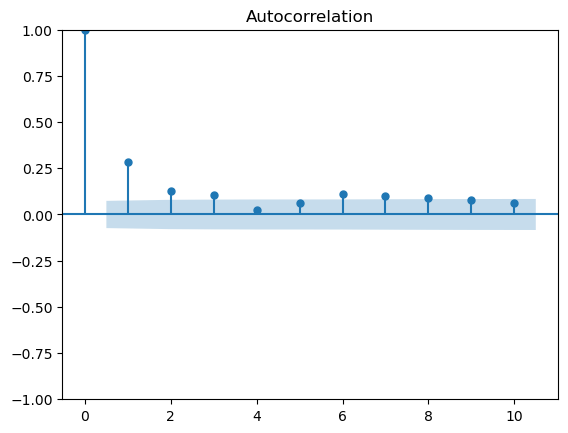

In [25]:
#reg res on t
res_model = smf.ols('res ~ t_numeric', data=data).fit()
res1 = res_model.resid
plot_acf(res1, lags = 10)

After removing the trend, it shows less autcorrelation with later lags but the correlologram shows that still we have serial autocorrelation with the lag 1 error

(e) Estimate an AR(1) model for res1. Test hypothesis of no AR(1) serial correlation in the errors of this model.


In [27]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox

# Fit AR(1) model
model_ar = AutoReg(res1, lags=1).fit()
print(model_ar.summary())

# Test residuals for serial correlation at lag 1
lb_test = acorr_ljungbox(model_ar.resid, lags=1, return_df=True)
print(lb_test)

# Interpretation
p_value = lb_test['lb_pvalue'].iloc[0]
if p_value < 0.05:
    print(f"Reject H₀: p-value = {p_value:.4f} < 0.05")
    print("→ Serial correlation exists in errors")
else:
    print(f"Fail to reject H₀: p-value = {p_value:.4f} >= 0.05")
    print("→ No evidence of serial correlation")





                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  708
Model:                     AutoReg(1)   Log Likelihood               -1337.262
Method:               Conditional MLE   S.D. of innovations              1.604
Date:                Tue, 18 Nov 2025   AIC                           2680.523
Time:                        22:44:43   BIC                           2694.206
Sample:                             1   HQIC                          2685.810
                                  708                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1769      0.061     -2.900      0.004      -0.296      -0.057
y.L1           0.2856      0.036      7.932      0.000       0.215       0.356
                                    Roots           

(f) Given your estimates in (b-e), what is your forecast of the mean daily maximum temperature in Cambridge in February 2018?


In [30]:
# ============================================================================
# PART (f): FORECAST FEBRUARY 2018
# ============================================================================

# 1. Seasonal component (from Part b - month dummies)
# February = month 2, January is reference (intercept)
seasonal_feb = model.params['Intercept'] + model.params['C(month)[T.2]']

# 2. Trend component (from Part d - res ~ t_numeric)
# February 2018: data ends Dec 2017 (708 obs), so Feb 2018 = 710th observation
t_feb2018 = len(data) + 2  # Jan 2018 = 709, Feb 2018 = 710
trend_feb = res_model.params['Intercept'] + res_model.params['t_numeric'] * t_feb2018

# 3. AR(1) component (from Part e - AR(1) on res1)
# Use res1 from January 2018 (last known value before forecast)
# res1 is residuals from trend regression, same length as data
res1_jan2018 = res1.iloc[-1]  # Last value = January 2018
phi = model_ar.params['y.L1']  # AR(1) coefficient
ar1_feb = phi * res1_jan2018

# 4. Combine: forecast = seasonal + trend + AR(1)
forecast_feb2018 = seasonal_feb + trend_feb + ar1_feb
print("FORECAST: Mean Daily Maximum Temperature - February 2018")
print(f"1. Seasonal component (month effect):     {seasonal_feb:.4f}°C")
print(f"2. Trend component (at t={t_feb2018}):    {trend_feb:.6f}")
print(f"3. AR(1) component (phi={phi:.4f}):       {ar1_feb:.6f}")
print(f"Forecast = {seasonal_feb:.4f} + {trend_feb:.6f} + {ar1_feb:.6f}")
print(f"         = {forecast_feb2018:.4f}°C")
print(f"\n✓ Forecasted mean daily maximum temperature in February 2018: {forecast_feb2018:.2f}°C")



FORECAST: Mean Daily Maximum Temperature - February 2018
1. Seasonal component (month effect):     7.4814°C
2. Trend component (at t=710):    0.000000
3. AR(1) component (phi=0.2856):       -0.206854
Forecast = 7.4814 + 0.000000 + -0.206854
         = 7.2745°C

✓ Forecasted mean daily maximum temperature in February 2018: 7.27°C
